In [499]:
import numpy as np 
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
plt.rcParams["figure.figsize"] = (15,5)
import tensorflow as tf

def Derivative_Phi (z):
  if linear :
    return np.array([  [2*z[0,0], 0, 0], 
                      [z[1,0], z[0,0], 0],
                      [z[2,0], 0, z[0,0]],
                      [0, 2*z[1,0], 0],
                      [0, z[2,0], z[1,0]],
                      [0, 0, 2*z[2,0]]     ])

  else :
    return np.array([ [2*z[0,0]  ,       0   ],
                        [ z[1,0]   ,   z[0,0]  ],
                        [   0      ,  2*z[1,0] ]  ]) 
  

def Q (z):
    return  z.T @ z 
    
def F (z):
  if linear :
    return np.array([[-1.01887, 0.90506, -0.00215], 
                    [0.82225, -1.07741, -0.17555],
                    [0, 0, -1]                  ])    @  z

  else :
    return np.array([[- z[0,0] + z[1,0]] , 
                    [ -0.5*z[0,0] - 0.5*z[1,0]*(1 -(np.cos(2*z[0,0])+2)**2)]]) 
    
def G (z):
  if linear :
    return np.array([[0],[0],[1]])
    
  else :
    return np.array([[0],
                     [(np.cos(2*z[0,0]) +2)]])

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def makeF1F2 (ms, d1, w1, m):
  temp = d1 @ w1 @ m.T
  cof1 = - (1/(8*ms)) * d1 @ w1
  cof2 = - (1/8) * (temp + temp.T) 

  f1 = np.zeros(cof1.shape)
  f2 = np.zeros(cof2.shape)

  for i in range(f1.shape[0]):
    for j in range(f1.shape[1]):
      if cof1 [i][j] > 0 : 
        f1 [i][j] =  2 * cof1 [i][j]
      else : f1 [i][j] =  0

  cof1 -= 0.5 * f1

  for i in range(f2.shape[0]):
    for j in range(f2.shape[1]):
      if cof2 [i][j] < 0 :
        f2 [i][j] = - cof2 [i][j]
      else : f2 [i][j] = 0.001
  
  cof2 += f2 

  for ii in range(f2.shape[0]):
    f2 [ii][ii] = np.abs(cof1[ii]) + np.sum(np.abs(cof2[ii])) + 1

  return f1, f2

In [504]:
linear = False
num_centers = 3

if linear :
  z = np.random.random((3,1)) - 0.5
  W1 = np.random.random((num_centers,1))   #np.random.random((6,1))                     # Weight Critic NN
  W2 = np.random.random((num_centers,1))   #np.random.random ((6,1))                    # Weight Actor(s) NN

else :
  z = (np.random.random((2, 1)) - 0.5 ) * 5
  W1 = np.random.random((num_centers,1))                         # Weight Critic NN
  W2 = np.random.random((num_centers,1))                       # Weight Actor(s) NN
  # W1 = np.ones((num_centers,1))   
  # W2 = np.ones((num_centers,1)) 

g = G(z)
print("\nZ :\n",z, "\n")
print("\nw1 :\n",W1, "\n")
print("\nw2 :\n",W2, "\n")



Z :
 [[ 0.13850975]
 [-0.16863259]] 


w1 :
 [[0.94914672]
 [0.60943058]
 [0.93309284]] 


w2 :
 [[0.02607237]
 [0.2565679 ]
 [0.86267103]] 



In [505]:
totalIter = 10000
alpha1 = 1  ; alpha2 =  (1/1)#*alpha1 
timeScale = 300 
R = np.ones((1,1)) / 1
q = 1
noise_coef = 0.1

# if linear : 
#   theM = np.zeros((6,6))
#   for i in range(2) :
#       theM [i,i] = 0.8
#   theM [2,2] = 1 
# else :
#   theM = np.zeros((5,5))
#   for i in range(2) :
#       theM [i,i] = 1

changeW1 = []  ;  changeW2 = [] ; all_Z = [] ; all_W1 = [] ; all_W2 = []
for iter in range (totalIter) :
  
  t = iter / timeScale
  all_W1 . append(W1.flatten())
  all_W2 .append(W2.flatten())
  all_Z.append(z.copy()) 

  dPhi = Derivative_Phi (z)
  actor =  - 0.5 * np.linalg.pinv(R)  @  g.T  @  dPhi.T  @  W2
  actor += (np.random.random(actor.shape) -0.5) * noise_coef
  dz =  (F(z) + g @ actor) #/ timeScale
  sigma2 =  dPhi @ dz
  normsigma2 = (sigma2.T @ sigma2) + 1 
  sigma2bar = sigma2 / normsigma2   
  D1bar =                dPhi @ g  @ g.T @ dPhi.T
  ms = normsigma2 
  m = sigma2 /  normsigma2 **2

  F1 , F2 = makeF1F2(ms, D1bar, W1 , m)  
  # F1 = np.ones((num_centers,1)) * 2000
  # F2 = np.ones((num_centers,num_centers)) * 1

  # term1 = -0.5 * F1 - (1/(8*ms)) * (D1bar@W1)  
  # temp = D1bar @ W1 @ m.T
  # term2 = F2 - (1/8) * (temp.T + temp)

  # ## for non linear example 
  # theM [1,2:] = term1.T 
  # theM [2:,[1]] = term1
  # theM [2: , 2:] = term2 

  # # for linear example 
  # theM [3,4:] = term1.T 
  # theM [-6:,3] = term1.flatten() 
  # theM [-6: , -6:] = term2 
  
  # np.linalg.cholesky(theM)   # check if F1 and F2 made the M Positive Definite

  W1Change =  alpha1 * (sigma2 / normsigma2 **2) * (sigma2.T @ W1 + q * Q(z) + actor.T @ R @ actor ) 
  # W2Change =  alpha2 * ((F2 @ W2 - F2 @ W1)                - (0.25 * D1bar @ W2 @ m.T @ W1))
  W2Change =  alpha2 * ((F2 @ W2 - F1 @ sigma2bar.T  @ W1) - (0.25 * D1bar @ W2 @ m.T @ W1)) 

  changeW1.append(W1Change)  ; changeW2.append(W2Change)

  W1 -= W1Change / timeScale
  W2 -= W2Change / timeScale

  z += dz / timeScale
  g = G (z) 


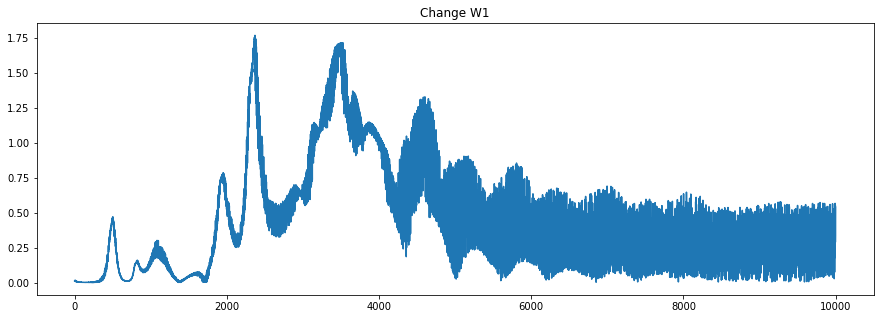

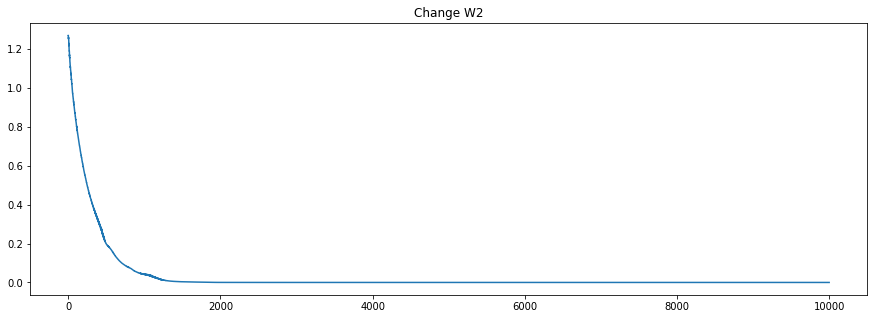

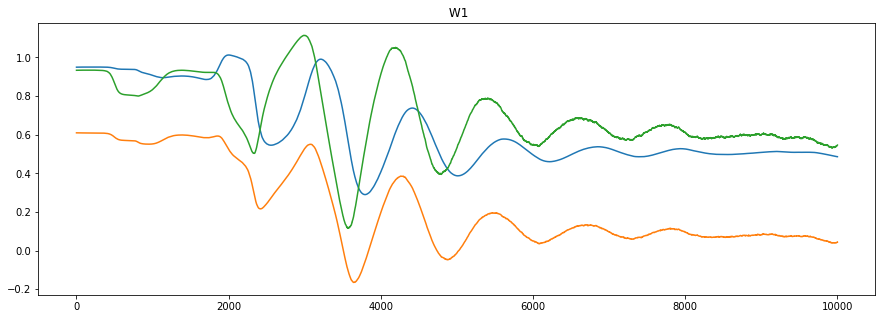

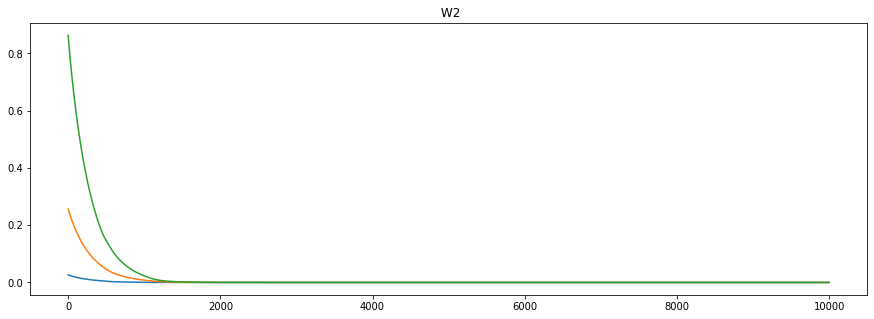

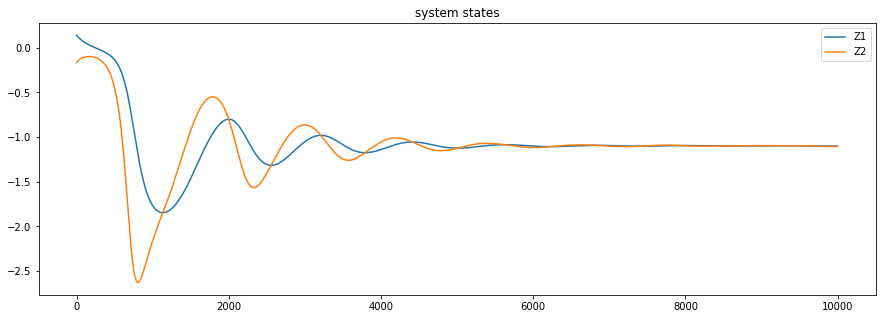

In [506]:
until = 10000
plt.plot(np.arange(totalIter), np.sum(np.abs(np.array(changeW1)), axis=1))
plt.title("Change W1")
plt.show()

plt.plot(np.arange(totalIter), np.sum(np.sum(np.abs(np.array(changeW2)), axis=2),axis=1))
plt.title("Change W2")
plt.show() 

plt.plot(np.arange(totalIter), all_W1)
plt.title(" W1")
plt.show() 

plt.plot(np.arange(totalIter), all_W2)
plt.title(" W2")
plt.show() 

plt.plot(np.arange(len(all_Z))[:until], [all_Z[i][0] for i in range(len(all_Z))][:until], label= "Z1")
plt.plot(np.arange(len(all_Z))[:until], [all_Z[i][1] for i in range(len(all_Z))][:until], label= "Z2")
if linear : 
  plt.plot(np.arange(len(all_Z)), [all_Z[i][2] for i in range(len(all_Z))], label= "Z3")
plt.title(" system states ")

plt.legend()
plt.show() 

In [507]:
print("\nw1 :\n",W1, "\n")
print("\nw2 :\n",W2, "\n")


w1 :
 [[0.48596652]
 [0.04464823]
 [0.54717665]] 


w2 :
 [[-0.]
 [ 0.]
 [ 0.]] 

